In [144]:
%matplotlib inline

import sympy as sp
sp.init_printing(use_latex ='mathjax')
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit as lf
import os
import seaborn as sns
import sys
sys.path.append('..')
from myheatmap import myheatmap
from lmfit import Model
import lmfit
from tabulate import tabulate
import matplotlib

verbose = False

sns.set_context('talk')

In [145]:
#Define all variables

#individual springs that correspond to individual masses
k1 = sp.symbols('k_1', real = True)
k2 = sp.symbols('k_2', real = True)

#springs that connect two masses
k12 = sp.symbols('k_12', real = True)

#damping coefficients
g1 = sp.symbols('g', real = True)
g2 = sp.symbols('g2', real = True)
 
#masses
m1 = sp.symbols('m1', real = True)
m2 = sp.symbols('m2', real = True)

#Driving force amplitude
F = sp.symbols('F', real = True)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d', real = True)

In [146]:
def syserror(x_found,x_set):
    return abs(x_found-x_set)/x_set

def complexamp(A,phi):
    return A * np.exp(1j*phi)

def rsqrd(model, data, plot=False, x=None, newfigure = True):
    SSres = sum((data - model)**2)
    SStot = sum((data - np.mean(data))**2)
    rsqrd = 1 - (SSres/ SStot)
    
    if plot:
        if newfigure:
            plt.figure()
        plt.plot(x,data, 'o')
        plt.plot(x, model, '--')
    
    return rsqrd

In [147]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2*m1 + 1j*wd*g1 + k1 + k12, -k12], [-k12, -wd**2*m2 + 
  1j*wd*g2 + k2 + k12]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F, -k12], [0, -wd**2*m2 + 1j*wd*g2 + k2 + k12]])

driven_m2 = sp.Matrix([[-wd**2*m1 + 1j*wd*g1 + k1 + k12, F], [-k12, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(), driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1) # Returns the argument (phase angle in radians) of a complex number. 
delta2 = sp.arg(Cr2) # sp.re(Cr2)/sp.cos(delta2) (this is the same thing)

#Wrap phases for plots

wrap1 = (delta1)%(2*sp.pi)
wrap2 = (delta2)%(2*sp.pi)

#Solve for amplitude coefficients
amp1 = sp.Abs(Cr1)
amp2 = sp.Abs(Cr2)

"""complexamp1 = amp1 * sp.exp(sp.I * sp.pi * delta1)
complexamp2 = amp2 * sp.exp(sp.I * sp.pi * delta2) """
complexamp1 = Cr1
complexamp2 = Cr2

reamp1 = sp.re(complexamp1)
imamp1 = sp.im(complexamp1)
reamp2 = sp.re(complexamp2)
imamp2 = sp.im(complexamp2)

if verbose:
    display(r"R1 Amplitude:")
    display(amp1)

    display(r"R2 Amplitude:")
    display(amp2)

    display(r"R1 complex amplitude:")
    display(complexamp1)
    
    display(r"R2 complex amplitude:")
    display(complexamp2)
    
    display("R1 Real amplitude:")
    display(reamp1)
    
    display("R1 Imaginary amplitude:")
    display(imamp1)
    
    display("R2 Real amplitude:")
    display(reamp2)
    
    display("R2 Imaginary amplitude:")
    display(imamp2)

#lambdify curves

c1 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), amp1)
t1 = sp.lambdify((wd, k1, k2, k12, g1, g2, F,  m1, m2), wrap1)

c2 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), amp2)
t2 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), wrap2)

re1 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), reamp1)
im1 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), imamp1)
re2 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), reamp2)
im2 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), imamp2)

#define functions

#curve = amplitude, theta = phase, e = error (i.e. noise)
def curve1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return c1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e
    
def theta1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return t1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) - 2*np.pi + e
    
def curve2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return c2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e
    
def theta2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return t2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) - 2*np.pi + e
    
def realamp1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return re1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e
    
def imamp1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return im1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e
    
def realamp2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return re2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e
    
def imamp2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return im2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e

In [148]:
#Use functions to make matrices of amplitude and phase for each resonator (with noise)

#define set values
k1_set = 12
k2_set = 27
k12_set = 1
g1_set = 1
g2_set = 0.5
F_set = 1
m1_set = 5
m2_set = 3

vals_set = [m1_set, m2_set, g1_set, g2_set, k1_set, k2_set, k12_set, F_set]

#define number of samples (i.e. range over which to vary the frequency)
n = 50

noiselevel = 1
use_complexnoise_only = True

amplitudenoisefactor1 = 0.005
amplitudenoisefactor2 = 0.0005
phasenoisefactor1 = 0.1
phasenoisefactor2 = 0.2
complexamplitudenoisefactor = 0.0005

#define noise (randn(n,) gives a array of normally-distributed random numbers of size n)
amp1_noise = noiselevel* amplitudenoisefactor1 * np.random.randn(n,)
phase1_noise = noiselevel* phasenoisefactor1 * np.random.randn(n,)
amp2_noise = noiselevel* amplitudenoisefactor2 * np.random.randn(n,)
phase2_noise = noiselevel* phasenoisefactor2 * np.random.randn(n,)
complex_noise = noiselevel* complexamplitudenoisefactor * np.random.randn(n,)

#define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5)
drive = np.linspace(0.1, 5, num = n)

R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)

R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)

def amp(a,b):
    return np.sqrt(a**2 + b**2)

usenoise = True

if usenoise: # add a random vector of positive and negative numbers to the curve.
    R1_real_amp = realamp1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, complex_noise)
    R1_im_amp   = imamp1  (drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, complex_noise)
    R2_real_amp = realamp2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, complex_noise)
    R2_im_amp   = imamp2  (drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, complex_noise)
    
    if use_complexnoise_only:
        R1_amp   = amp(R1_real_amp, R1_im_amp)
        R2_amp   = amp(R2_real_amp, R2_im_amp)
        R1_phase = np.unwrap(np.angle(R1_real_amp + R1_im_amp*1j))
        R2_phase = np.unwrap(np.angle(R2_real_amp + R2_im_amp*1j))
        
        
                
    else:
        R1_amp   = curve1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, amp1_noise)
        R1_phase = theta1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, phase1_noise)
        R2_amp   = curve2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, amp2_noise)
        R2_phase = theta2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, phase2_noise)
        
else:
    R1_amp = R1_amp_noiseless
    R1_phase = R1_phase_noiseless
    R2_amp = R2_amp_noiseless
    R2_phase = R2_phase_noiseless
    R1_real_amp = R1_real_amp_noiseless
    R1_im_amp = R1_im_amp_noiseless
    R2_real_amp = R2_real_amp_noiseless
    R2_im_amp = R2_im_amp_noiseless
    
def listlength(list1):
    try:
        length = len(list1)
    except TypeError:
        length = 1
    return length

if use_complexnoise_only:
    def noisyR1ampphase(drive):       
        n = listlength(drive)
        ## calculate fresh the noise of amplitude 1. This is an independent noise calculation.
        R1_real_amp = realamp1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* complexamplitudenoisefactor * np.random.randn(n,))
        R1_im_amp   = imamp1  (drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* complexamplitudenoisefactor * np.random.randn(n,))
        return amp(R1_real_amp,R1_im_amp), np.angle(R1_real_amp + R1_im_amp*1j)

    def noisyR2ampphase(drive):
        n = listlength(drive)
        ## calculate fresh the noise of amplitude. This is an independent noise calculation.
        R2_real_amp = realamp2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* complexamplitudenoisefactor * np.random.randn(n,))
        R2_im_amp   = imamp2  (drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* complexamplitudenoisefactor * np.random.randn(n,))
        return amp(R2_real_amp,R2_im_amp), np.angle(R2_real_amp + R2_im_amp*1j)

else:
    def noisyR1ampphase(drive):
        n = listlength(drive)
        a = curve1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* amplitudenoisefactor1 * np.random.randn(n,))
        p = theta1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* phasenoisefactor1 * np.random.randn(n,))
        return a,p

    def noisyR2ampphase(drive):
        n = listlength(drive)
        a = curve2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* amplitudenoisefactor2 * np.random.randn(n,))
        p = theta2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, noiselevel* phasenoisefactor2 * np.random.randn(n,))
        return a,p

In [169]:
R1_amp

array([0.07669533, 0.0777112 , 0.08038992, 0.08140471, 0.08559548,
       0.08869317, 0.09536586, 0.1027078 , 0.11128938, 0.12472287,
       0.14217436, 0.16982382, 0.21365741, 0.28973527, 0.44040241,
       0.62175908, 0.44111927, 0.26946443, 0.18434131, 0.13526163,
       0.10708573, 0.0874236 , 0.07273369, 0.06244789, 0.05320157,
       0.04802831, 0.04221272, 0.03740333, 0.03374093, 0.03061783,
       0.02760415, 0.02578721, 0.02451481, 0.02274556, 0.02001923,
       0.01902026, 0.01810555, 0.01693968, 0.01568766, 0.01495414,
       0.01477685, 0.01361239, 0.012164  , 0.01149434, 0.01091351,
       0.01159215, 0.01009054, 0.00948992, 0.0095203 , 0.00908897])

In [170]:
R2_amp

array([0.00216492, 0.00227983, 0.00341928, 0.0023726 , 0.00344238,
       0.00270797, 0.00405231, 0.00456768, 0.00403465, 0.00506013,
       0.00523351, 0.00699727, 0.00976713, 0.01314197, 0.02070575,
       0.03083931, 0.0233485 , 0.01535848, 0.01154487, 0.00759606,
       0.00742444, 0.00679268, 0.00587273, 0.00598486, 0.00513905,
       0.00660322, 0.00681111, 0.00784776, 0.01076165, 0.01709124,
       0.01746762, 0.00894011, 0.00444338, 0.00275741, 0.00316884,
       0.00206559, 0.00126965, 0.00102353, 0.00107142, 0.00069463,
       0.00057582, 0.00031976, 0.00096153, 0.00092804, 0.00085526,
       0.00086739, 0.00046028, 0.00059571, 0.00015936, 0.00014388])

In [171]:
R1_phase

array([-0.01754602, -0.02399509, -0.01745487, -0.04295812, -0.03887614,
       -0.06333351, -0.06116373, -0.07486921, -0.1047486 , -0.12428473,
       -0.16544179, -0.20739719, -0.27720186, -0.41752608, -0.72369094,
       -1.47740976, -2.2937356 , -2.63503911, -2.7827254 , -2.86907174,
       -2.91345411, -2.94549316, -2.97379514, -2.98830209, -3.01652609,
       -3.00712332, -3.02381448, -3.03894523, -3.04207636, -3.03903636,
       -3.06802507, -3.0687839 , -3.04781397, -3.04909546, -3.09908544,
       -3.08425927, -3.07047701, -3.07395202, -3.08850546, -3.07921429,
       -3.04143036, -3.0643699 , -3.11811736, -3.12305779, -3.12482021,
       -3.02923222, -3.1080402 , -3.12245639, -3.07808228, -3.08022544])

In [172]:
R2_phase

array([-0.36466017, -0.30773873,  0.12552448, -0.39518902,  0.04389199,
       -0.38796851,  0.0485353 ,  0.06204805, -0.23085241, -0.12536406,
       -0.38695624, -0.27409561, -0.22265116, -0.43834979, -0.78004456,
       -1.52623253, -2.3380602 , -2.67005679, -2.80067776, -3.00584508,
       -2.96551912, -2.98858386, -3.08286873, -3.06944701, -3.27387416,
       -3.0976886 , -3.22400833, -3.37046285, -3.53871225, -4.02952877,
       -5.1295322 , -5.65157164, -5.89963803, -6.04564354, -5.86696424,
       -5.95767661, -6.1254681 , -6.14256263, -5.99828669, -6.17377622,
       -7.93916836, -7.10545435, -5.7903516 , -5.76194613, -5.7495046 ,
       -8.42055457, -5.8697138 , -5.75105791, -7.64334317, -7.64909357])

In [149]:
#Choose points for SVD

p = [int(50/4), int(115/4)] #indices of frequencies to use



table = []

for i in range(len(p)):
    table.append([drive[p[i]], R1_amp[p[i]], R1_phase[p[i]], R2_amp[p[i]], R2_phase[p[i]], 
                  complexamp(R1_amp[p[i]],R1_phase[p[i]] ),
                  complexamp(R2_amp[p[i]], R2_phase[p[i]]),
                 syserror(R1_amp[p[i]], R1_amp_noiseless[p[i]]),
                 (R1_phase[p[i]] - R1_phase_noiseless[p[i]]),
                 syserror(R2_amp[p[i]],R2_amp_noiseless[p[i]]),
                 (R2_phase[p[i]]-R2_phase_noiseless[p[i]])])
                 
    
df = pd.DataFrame(data = table, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase',
                                           'Z1', 'Z2',
                                           'R1Amp_syserror', 'R1Phase_diff', 'R2Amp_syserror', 'R2Phase_diff'])

df

,drive,R1Amp,R1Phase,R2Amp,R2Phase,Z1,Z2,R1Amp_syserror,R1Phase_diff,R2Amp_syserror,R2Phase_diff
0,1.3,0.213657,-0.277202,0.009767,-0.222651,0.205501-0.058471j,0.009526-0.002157j,0.002166,0.003903,0.050915,0.086793
1,2.9,0.033741,-3.042076,0.010762,-3.538712,-0.033574-0.003352j,-0.009924+0.004162j,0.004935,-0.004032,0.007706,-0.018425


Simulated spectra data, as if from experiment
Resonant frequencies expected at 1.5491933384829668 and 3.0


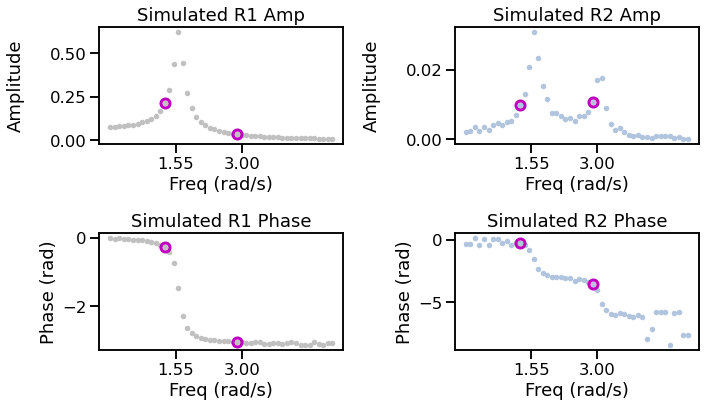

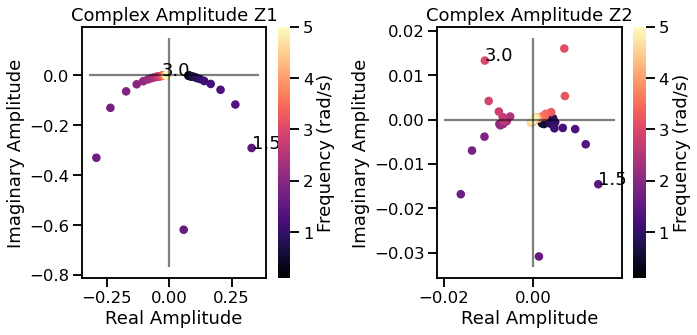

In [150]:
#Plots of simulated spectra

res1 = np.sqrt(k1_set/m1_set)
res2 = np.sqrt(k2_set/m2_set)

print('Simulated spectra data, as if from experiment')
print('Resonant frequencies expected at ' 
      + str(res1) + ' and ' 
      + str(res2))

fig, ((ax1, ax3),(ax2,ax4)) = plt.subplots(2, 2, figsize = (10,6))

ax1.plot(drive, R1_amp, '.', color = 'silver')
ax1.set_xlabel('Freq (rad/s)')
ax1.set_ylabel('Amplitude\n')
ax1.set_title('Simulated R1 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax1.plot(df.drive[i], df.R1Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
        
ax2.plot(drive, R1_phase, '.', color = 'silver')
ax2.set_xlabel('Freq (rad/s)')
ax2.set_ylabel('Phase (rad)')
ax2.set_title('Simulated R1 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax2.plot(df.drive[i], df.R1Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)
        

ax3.plot(drive, R2_amp, '.', color = 'lightsteelblue')
ax3.set_xlabel('Freq (rad/s)')
ax3.set_ylabel('Amplitude\n')
ax3.set_title('Simulated R2 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax3.plot(df.drive[i], df.R2Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
    

ax4.plot(drive, R2_phase, '.', color = 'lightsteelblue')
ax4.set_xlabel('Freq (rad/s)')
ax4.set_ylabel('Phase (rad)')
ax4.set_title('Simulated R2 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax4.plot(df.drive[i], df.R2Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)
        
for ax in [ax1,ax2,ax3,ax4]:
      plt.sca(ax)
      plt.xticks([res1, res2])
    
plt.tight_layout()

#Calculate complex amplitudes of spectra

Z1 = complexamp(R1_amp, R1_phase)
Z2 = complexamp(R2_amp, R2_phase)

def plotcomplex(Z, c, title = 'Complex Amplitude', cbar_label='Frequency (rad/s)', label_markers=[], ax=plt.gca(), s=50, cmap = 'magma'):
    plt.sca(ax)
    sc = ax.scatter(np.real(Z), np.imag(Z), s=s, c = c, cmap = cmap ) # s is marker size
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label(cbar_label)
    ax.set_xlabel('Real Amplitude')
    ax.set_ylabel('Imaginary Amplitude')
    ax.axis('equal');
    plt.title(title)
    plt.gcf().canvas.draw()
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    plt.vlines(0, ymin=ymin, ymax = ymax, colors = 'k', linestyle='solid', alpha = .5)
    plt.hlines(0, xmin=xmin, xmax = xmax, colors = 'k', linestyle='solid', alpha = .5)
    #ax.plot([0,1],[0,0], lw=10,transform=ax.xaxis.get_transform() )#,transform=ax.xaxis.get_transform() ) #transform=ax.transAxes
    
    # label markers that are closest to the desired frequencies
    for label in label_markers:
        absolute_val_array = np.abs(drive - label)
        label_index = absolute_val_array.argmin()
        closest_element = c[label_index]
        plt.annotate(text=str(round(closest_element,2)), xy=(np.real(Z[label_index]), np.imag(Z[label_index])) )


fig, (ax5, ax6) = plt.subplots(1, 2, figsize = (10,5))

plotcomplex(Z1, drive, 'Complex Amplitude Z1', ax=ax5, label_markers=[res1,res2])
plotcomplex(Z2, drive, 'Complex Amplitude Z2', ax=ax6, label_markers=[res1,res2])

      
plt.tight_layout()

In [151]:
#Define function to calculate phase correction and complex amplitudes

print('Simulated response vector data, as if from experiment')

ampComplex = []

def complexAmp(df):
    
    #Use amplitude and phase to calculate complex amplitude
    Z1 = df['R1Amp'] * np.exp(1j * df['R1Phase'])
    Z2 = df['R2Amp'] * np.exp(1j * df['R2Phase'])
    
    #Add complex amplitude to table to append to dataframe
    ampComplex.append([Z1, Z2])

for i in range(df.shape[0]):
    complexAmp(df.iloc[i])

df['R1AmpCom'], df['R2AmpCom'] = np.transpose(ampComplex)

df

Simulated response vector data, as if from experiment


,drive,R1Amp,R1Phase,R2Amp,R2Phase,Z1,Z2,R1Amp_syserror,R1Phase_diff,R2Amp_syserror,R2Phase_diff,R1AmpCom,R2AmpCom
0,1.3,0.213657,-0.277202,0.009767,-0.222651,0.205501-0.058471j,0.009526-0.002157j,0.002166,0.003903,0.050915,0.086793,0.205501-0.058471j,0.009526-0.002157j
1,2.9,0.033741,-3.042076,0.010762,-3.538712,-0.033574-0.003352j,-0.009924+0.004162j,0.004935,-0.004032,0.007706,-0.018425,-0.033574-0.003352j,-0.009924+0.004162j


[1.42758938e+00 5.19934135e-01 2.88993823e-01 1.94509714e-01
 8.82017538e-02 3.36454891e-02 6.78380357e-04 1.89107883e-04]


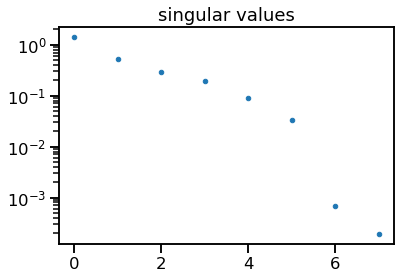

In [152]:
#Singular Value Decomposition

verbose = False

#define which two points to use for analysis
vals1 = df.loc[0]
vals2 = df.loc[1]
if verbose:
    display("vals1:")
    display(vals1)
    display("vals2:")
    display(vals2)

#define values for svd
d1 = vals1['drive']
d1Z1 = vals1['R1AmpCom']
d1Z2 = vals1['R2AmpCom']

d2 = vals2['drive']
d2Z1 = vals2['R1AmpCom']
d2Z2 = vals2['R2AmpCom']

#Define Matrix M
M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
        [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
        [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
        [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
        [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
        [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
        [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
        [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

if verbose:
    display("M matrix:")
    display(M)

#SVD
u, s, vh = np.linalg.svd(M, full_matrices = True)
#u, s, vh = sc.linalg.svd(M, full_matrices = False, lapack_driver = 'gesvd')

# the smallest singular value is always the last one, index -1
print(s)

plt.semilogy(s, '.')
plt.title('singular values');

In [153]:
# singular vectors. # M1, M2, G1, G2, K1, K2, K12, FD
vh

array([[ 4.34431469e-02+0.j, -2.27799651e-04+0.j, -4.35099146e-02+0.j,
         1.58327832e-05+0.j, -8.93948932e-02+0.j,  9.81605695e-05+0.j,
        -9.11478249e-02+0.j,  9.89909160e-01+0.j],
       [-8.64669977e-01+0.j,  7.01686776e-03+0.j, -4.55944856e-02+0.j,
        -4.75373032e-04+0.j,  3.31006881e-01+0.j, -2.96417322e-03+0.j,
         3.61682939e-01+0.j,  9.91394074e-02+0.j],
       [ 9.75184001e-02+0.j,  5.54541384e-03+0.j, -9.90379383e-01+0.j,
        -3.50354056e-04+0.j,  4.00340581e-02+0.j, -2.22180646e-03+0.j,
         8.15764962e-02+0.j, -3.66821346e-02+0.j],
       [-3.30233172e-01+0.j, -1.59401154e-01+0.j, -1.00583164e-01+0.j,
         8.77583717e-03+0.j,  1.40327055e-01+0.j,  5.78375584e-02+0.j,
        -9.10259162e-01+0.j, -6.11124209e-02+0.j],
       [-4.93164883e-02+0.j,  9.80973135e-01+0.j, -1.06950878e-02+0.j,
         8.26561647e-03+0.j,  2.07496919e-02+0.j, -1.02189290e-01+0.j,
        -1.55221379e-01+0.j, -1.04885261e-02+0.j],
       [-2.78429725e-03+0.j,  8.025

In [154]:
print("Checking the python-normalization")

vect =vh[-1]
sq = [el**2 for el in vect]
sum(sq)

Checking the python-normalization


(1.0000000000000002+0j)

In [164]:
[M1, M2, G1, G2, K1, K2, K12, FD] = vh[-1]

vals = [['Norm m1', 'Norm m2', 'Norm g1', 'Norm g2', 'Norm k1', 'Norm k2','Norm c12', 'Norm Driving Force']]
vals.append((M1, M2, G1, G2, K1, K2, K12, FD))

print("Python-Normalized singular vector corresponding to elements vector")
print(tabulate(vals, headers = 'firstrow', tablefmt = 'fancy_grid'))

Python-Normalized singular vector corresponding to elements vector
╒═══════════╤═════════════╤════════════╤═════════════╤═══════════╤════════════╤═════════════╤══════════════════════╕
│   Norm m1 │     Norm m2 │    Norm g1 │     Norm g2 │   Norm k1 │    Norm k2 │    Norm c12 │   Norm Driving Force │
╞═══════════╪═════════════╪════════════╪═════════════╪═══════════╪════════════╪═════════════╪══════════════════════╡
│ -0.359278 │ -0.00951954 │ -0.0702248 │ -0.00104389 │ -0.923825 │ -0.0859352 │ -0.00334922 │           -0.0710484 │
╘═══════════╧═════════════╧════════════╧═════════════╧═══════════╧════════════╧═════════════╧══════════════════════╛


C:\Users\vhorowit\Anaconda3\lib\site-packages\tabulate.py:595: ComplexWarning: Casting complex values to real discards the imaginary part
  conv(string)
C:\Users\vhorowit\Anaconda3\lib\site-packages\tabulate.py:996: ComplexWarning: Casting complex values to real discards the imaginary part
  return format(float(val), floatfmt)


Results of analysis versus set values:
The python normalization loses one degree of freedom, so we must be able to independently determine one element; say it's the driving force
How good are the 1D nullspace results?


labels,m1,m2,g1,g2,k1,k2,c12,Driving Force
labels,m1,m2,g1,g2,k1,k2,c12,Driving Force
from_svd,5.056807,0.133987,0.988407,0.014693,13.002745,1.20953,0.04714,1.0
set,5,3,1,0.5,12,27,1,1
syserror,0.011361,0.955338,0.011593,0.970615,0.083562,0.955203,0.95286,0.0


Noise level: 1


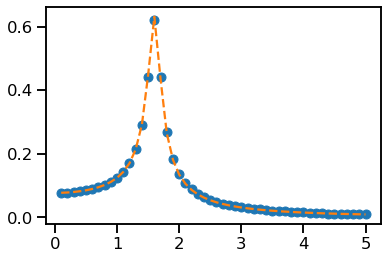

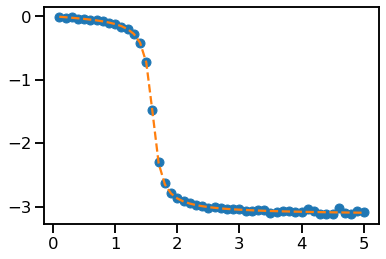

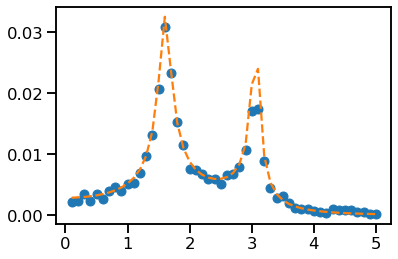

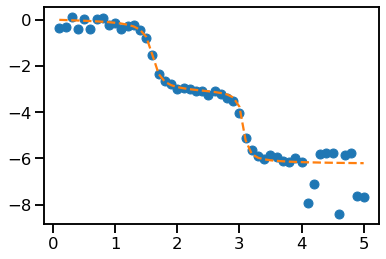

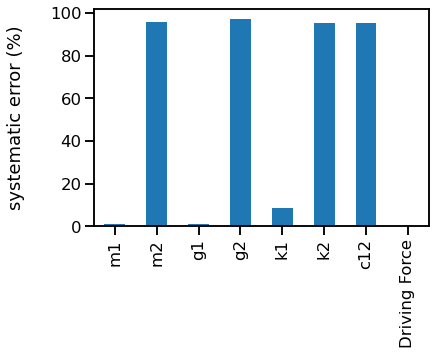

R1 Amp Rsqrd =  0.9996922472356681 
R1 Phase Rsqrd =  0.9998109082313824 
R2 Amp Rsqrd =  0.9626805772398509 
R2 Phase Rsqrd =  0.9568164505159814


In [165]:
#View vh array and assign variables to proper row vector

print('Results of analysis versus set values:')
print("The python normalization loses one degree of freedom, \
so we must be able to independently determine one element; say it's the driving force")

def normalize_elements_by_force(M1, M2, G1, G2, K1, K2, K12, FD, F_set):
    c = F_set / FD
    elements = (M1 * c, M2 * c, G1 * c, G2 * c, K1 * c, K2 * c, K12 * c, FD * c)
    return elements

elements = normalize_elements_by_force(M1, M2, G1, G2, K1, K2, K12, FD, F_set)
elements = [element.real for element in elements if element.imag == 0 ]
syserrors = [syserror(elements[i], vals_set[i]) for i in range(len(elements))]

vals2 = [['m1', 'm2', 'g1', 'g2', 'k1', 'k2','c12', 'Driving Force']]
vals2.append(elements)
vals2.append(vals_set)
vals2.append(syserrors)

M1, M2, G1, G2, K1, K2, K12, FD = elements

#print(tabulate(vals2, headers = 'firstrow', tablefmt = 'fancy_grid'))

#Calculate Rsqrd compared to 1D nullspace to test the 1D nullspace model

plotting = True

amp1_rsqrd = rsqrd(model=curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), data=R1_amp, plot=plotting, x=drive)
phase1_rsqrd = rsqrd(data=R1_phase, model=theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), plot=plotting, x=drive)
amp2_rsqrd = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), plot=plotting, x=drive)
phase2_rsqrd = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), plot=plotting, x=drive)

print("How good are the 1D nullspace results?")

## Calculate systematic error to test the 1D nullspace results

elementsdf = pd.DataFrame(vals2, index = ['labels', 'from_svd', 'set', "syserror"])
new_header = elementsdf.iloc[0] 
elementsdf.columns = new_header

display(elementsdf)

plt.figure()
print('Noise level: ' + str(noiselevel))
(elementsdf.transpose()['syserror']*100).plot(kind='bar')
plt.gca().set_ylabel('systematic error (%)\n')
plt.gca().set_xlabel('');
plt.show()

print("R1 Amp Rsqrd = ", amp1_rsqrd,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd,
      "\nR2 Amp Rsqrd = ", amp2_rsqrd,
      "\nR2 Phase Rsqrd = ", phase2_rsqrd)

Results of analysis versus set values:
If the null-space is 2D, we must be able to independently determine two elements; say it's m1 and m2


labels,m1,m2,g1,g2,k1,k2,c12,Driving Force
labels,m1,m2,g1,g2,k1,k2,c12,Driving Force
from_svd,5.0,3.0,0.980059,0.326308,11.933477,27.040781,1.046549,0.99568
set,5,3,1,0.5,12,27,1,1
syserror,0.0,0.0,0.019941,0.347384,0.005544,0.00151,0.046549,0.00432


How good are the 2D nullspace results?
Noise level: 1


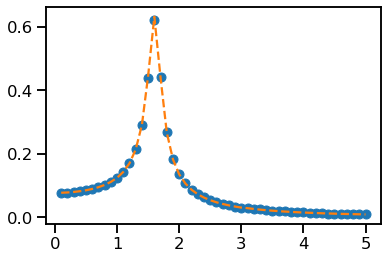

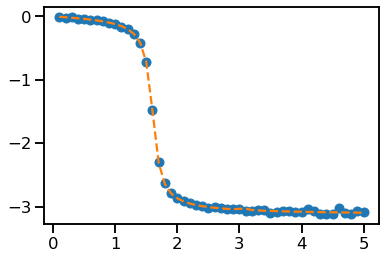

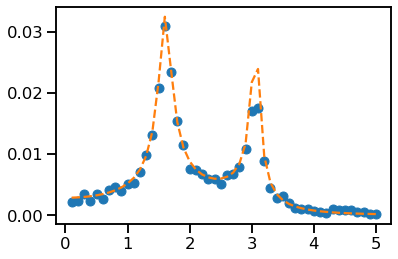

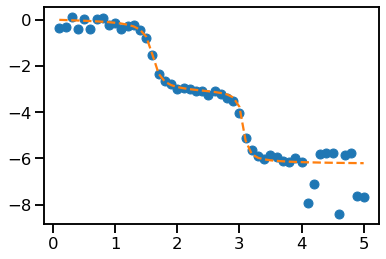

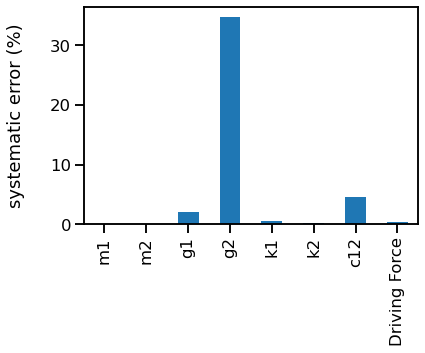

R1 Amp Rsqrd =  0.9997817600540291 
R1 Phase Rsqrd =  0.9998153218180329 
R2 Amp Rsqrd =  0.9628410562224416 
R2 Phase Rsqrd =  0.9568104661025185


In [157]:
## what if the null-space is 2D?

#View vh array and assign variables to proper row vector

print('Results of analysis versus set values:')
print("If the null-space is 2D, we must be able to independently determine two elements; say it's m1 and m2")
## but it would be cool if it were k1/m1 and k2/m2 because that should be known from the measured resonant frequencies

# elements vector: 'm1', 'm2', 'g1', 'g2', 'k1', 'k2','c12', 'Driving Force'
vect1 = vh[-1]
vect2 = vh[-2]

# find linear combination such that:
# a * vect1[0] + b * vect2[0] = m1_set   and
# a * vect1[1] + b * vect2[1] = m2_set
## But this rearranges to:

coefa = ( vect2[1] * m1_set - m2_set * vect2[0] ) / (vect2[1]*vect1[0] - vect1[1]*vect2[0] )
coefb = (vect1[1]*m1_set - m2_set *vect1[0] ) /(vect1[1]*vect2[0] - vect2[1]*vect1[0] )

elements = [coefa*vect1[k]+coefb*vect2[k]  for k in range(len(vect1)) ]
elements = [element.real for element in elements if element.imag == 0 ]

syserrors = [syserror(elements[i], vals_set[i]) for i in range(len(elements))]

vals3 = [['m1', 'm2', 'g1', 'g2', 'k1', 'k2','c12', 'Driving Force']]
vals3.append(elements)
vals3.append(vals_set)
vals3.append(syserrors)

#Calculate Rsqrd compared to 2D nullspace to test the 2D nullspace model
M1, M2, G1, G2, K1, K2, K12, FD = elements

plotting = True

amp1_rsqrd2D = rsqrd(model=curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), data=R1_amp, plot=plotting, x=drive)
phase1_rsqrd2D = rsqrd(data=R1_phase, model=theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), plot=plotting, x=drive)
amp2_rsqrd2D = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), plot=plotting, x=drive)
phase2_rsqrd2D = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), plot=plotting, x=drive)

elementsdf3 = pd.DataFrame(vals3, index = ['labels', 'from_svd', 'set', "syserror"])
new_header3 = elementsdf3.iloc[0] 
elementsdf3.columns = new_header3

display(elementsdf3)

print("How good are the 2D nullspace results?")

plt.figure()
print('Noise level: ' + str(noiselevel))
(elementsdf3.transpose()['syserror']*100).plot(kind='bar')
plt.gca().set_ylabel('systematic error (%)\n')
plt.gca().set_xlabel('');
plt.show()


print("R1 Amp Rsqrd = ", amp1_rsqrd2D,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd2D,
      "\nR2 Amp Rsqrd = ", amp2_rsqrd2D,
      "\nR2 Phase Rsqrd = ", phase2_rsqrd2D)


C:\Users\vhorowit\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\vhorowit\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


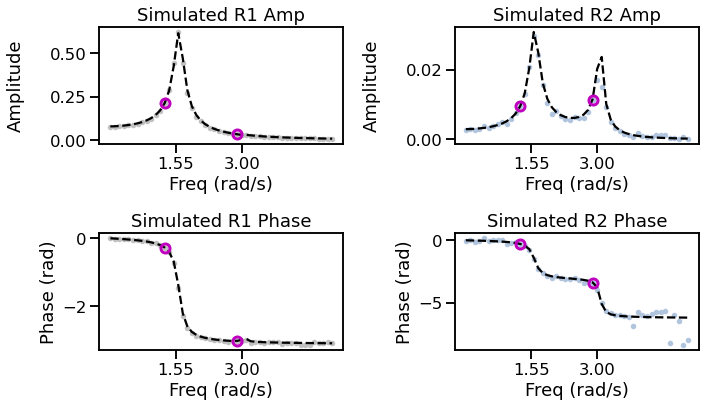

In [17]:
#Plots of singular value decomposition

fig, ((ax1, ax3),(ax2,ax4)) = plt.subplots(2, 2, figsize = (10,6))

ax1.plot(drive, R1_amp, '.', color = 'silver', label='simulated data') # simulated data
ax1.plot(drive, curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black', label='SVD results') # predicted spectrum from SVD)
ax1.set_xlabel('Freq (rad/s)')
ax1.set_ylabel('Amplitude\n')
ax1.set_title('Simulated R1 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax1.plot(df.drive[i], df.R1Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
        
ax2.plot(drive, R1_phase, '.', color = 'silver')
ax2.plot(drive, theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black')
ax2.set_xlabel('Freq (rad/s)')
ax2.set_ylabel('Phase (rad)')
ax2.set_title('Simulated R1 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax2.plot(df.drive[i], df.R1Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)
        

ax3.plot(drive, R2_amp, '.', color = 'lightsteelblue')
ax3.plot(drive, curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black')
ax3.set_xlabel('Freq (rad/s)')
ax3.set_ylabel('Amplitude\n')
ax3.set_title('Simulated R2 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax3.plot(df.drive[i], df.R2Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
    

ax4.plot(drive, R2_phase, '.', color = 'lightsteelblue')
ax4.plot(drive, theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black')
ax4.set_xlabel('Freq (rad/s)')
ax4.set_ylabel('Phase (rad)')
ax4.set_title('Simulated R2 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax4.plot(df.drive[i], df.R2Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)

for ax in [ax1, ax2, ax3, ax4]:
    plt.sca(ax)
    plt.xticks([res1, res2])

plt.tight_layout()

**Sweep through possible point differences**

In [18]:
#Code that loops through points of different spacing

#n = 30

#initiate arrays for badness of fit values
fits = []

# initate array for systematic error sum of squares values
results = []

#Start table, to be indexed by frequency indices
tab = []

# Loop over possible combinations of frequency indices, i1 and i2
for i1 in range(n):
    freq1 = drive[i1]
   
    for i2 in range(n):
        freq2 = drive[i2]
        
        ## Recalculate the noise for each pair. (I checked: Python doesn't cache the function returns.)
        
        # Values for frequency 1
        na11,np11 = noisyR1ampphase(freq1)
        na21,np21 = noisyR2ampphase(freq1)
        freq1_data = [[freq1, na11, np11, na21,np21]]
        freq1_df_vals = pd.DataFrame(data = freq1_data, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])
        
        # Values for frequency 2
        na12,np12 = noisyR1ampphase(freq2)
        na22,np22 = noisyR2ampphase(freq2)
        freq2_data = [[freq2, na12,np12, na22,np22]]
        freq2_df_vals = pd.DataFrame(data = freq2_data, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])

        #Calculate complex values   
        ampComplex = []

        #Complex amplitudes of both resonators with frequency 1
        Z1_1 = R1_amp[i1] * np.exp(1j * R1_phase[i1])
        Z2_1 = R2_amp[i1] * np.exp(1j * R2_phase[i1])
        ampComplex.append([Z1_1, Z2_1])

        #Complex amplitudes of both resonators with frequency 2
        Z1_2 = R1_amp[i2] * np.exp(1j * R1_phase[i2])
        Z2_2 = R2_amp[i2] * np.exp(1j * R2_phase[i2])
        ampComplex.append([Z1_2, Z2_2])

        freq1_df_vals['R1AmpCom'] = Z1_1
        freq1_df_vals['R2AmpCom'] = Z2_1
        freq2_df_vals['R1AmpCom'] = Z1_2
        freq2_df_vals['R2AmpCom'] = Z2_2

        #define which two points to use for analysis
        vals1 = freq1_df_vals.loc[0]
        vals2 = freq2_df_vals.loc[0]

        #define values for svd
        d1 = vals1['drive']
        d1Z1 = vals1['R1AmpCom']
        d1Z2 = vals1['R2AmpCom']

        d2 = vals2['drive']
        d2Z1 = vals2['R1AmpCom']
        d2Z2 = vals2['R2AmpCom']

        M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
            [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
            [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
            [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
            [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
            [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
            [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
            [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

        #SVD,  u and vh are 2D unitary arrays and s is a 1D array of the input matrix's singular values
        u, s, vh = np.linalg.svd(M, full_matrices = True)
       
        # extract parameters found by SVD
        #assign variables # mass of resonator 1, mass 2, damping 1, damping 2, stiffness 1, stiffness 2, coupling stiffness, force
        [M1, M2, G1, G2, K1, K2, K12, FD] = vh[-1] # the 7th singular value is the smallest one (closest to zero)

        # too add: normalize elements vector to the force, assuming 1D nullspace
        M1, M2, G1, G2, K1, K2, K12, FD = normalize_elements_by_force(M1, M2, G1, G2, K1, K2, K12, FD, F_set)
                
        # Alternative check: 
        # calculate how close the SVD-determined parameters are compared to the originally set parameters

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, G1, G2, K1, K2, K12, FD
        K1syserror = syserror(K1,k1_set)
        K2syserror = syserror(K2,k2_set)
        K12syserror = syserror(K12,k12_set)
        G1syserror = syserror(G1,g1_set)
        G2syserror = syserror(G2,g2_set)
        Fsyserror = syserror(FD,F_set)
        m1syserror = syserror(M1,m1_set)
        m2syserror = syserror(M2,m2_set)
        parametererror = np.sqrt((K1syserror**2 + K2syserror**2 + K12syserror**2 + G1syserror**2 + G2syserror**2 + Fsyserror**2 + \
                        m1syserror**2 + m2syserror**2)/8)
        results.append([drive[i1],
                          drive[i2],
                          drive[i2] - drive[i1],
                          M1, M2, G1, G2, K1, K2, K12, FD,
                          K1syserror,
                          K2syserror,
                          K12syserror,
                          G1syserror,
                          G2syserror,
                          Fsyserror,
                          m1syserror,
                          m2syserror,
                          parametererror,
                     np.sum(R1_amp - curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2, 
                    np.sum((R1_phase - theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                    np.sum((R2_amp - curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                    np.sum((R2_phase - theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                        s[-1],s[-2],
                       R1_amp_noiseless[i1], R1_phase_noiseless[i1], R2_amp_noiseless[i1], R2_phase_noiseless[i1],
                       R1_amp_noiseless[i2], R1_phase_noiseless[i2], R2_amp_noiseless[i2], R2_phase_noiseless[i2],
                       R1_phase_noiseless[i2]-R1_phase_noiseless[i1]])
        

resultsdf = pd.DataFrame(data=results, columns = ['Freq1', 
                                                    'Freq2', 'Difference',
                                                    'M1', 'M2', 'G1', 'G2', 'K1', 'K2', 'K12', 'FD',
                                                    'K1syserror',
                                                    'K2syserror',
                                                    'K12syserror',
                                                    'G1syserror',
                                                    'G2syserror',
                                                    'Fsyserror',
                                                    'm1syserror',
                                                    'm2syserror',
                                                    'parametererror','R1AmpFit', 'R1PhaseFit', 'R2AmpFit', 'R2PhaseFit',
                                                  'smallest singular value', 'second smallest singular value',
                                                 'R1_amp_noiseless_a', 'R1_phase_noiseless_a', 'R2_amp_noiseless_a', 'R2_phase_noiseless_a',
                                                 'R1_amp_noiseless_b', 'R1_phase_noiseless_b', 'R2_amp_noiseless_b', 'R2_phase_noiseless_b', 'R1_phase_diff'])

In [19]:
resultsdf.head()

,Freq1,Freq2,Difference,M1,M2,G1,G2,K1,K2,K12,...,second smallest singular value,R1_amp_noiseless_a,R1_phase_noiseless_a,R2_amp_noiseless_a,R2_phase_noiseless_a,R1_amp_noiseless_b,R1_phase_noiseless_b,R2_amp_noiseless_b,R2_phase_noiseless_b,R1_phase_diff
0,0.1,0.1,0.0,-858.153384,-11.332636,1.117434,4.179343,3.837128,14.427803,0.525709,...,1.149186e-19,0.077432,-0.007748,0.002768,-0.009536,0.077432,-0.007748,0.002768,-0.009536,0.000000
1,0.1,0.2,0.1,4.977229,830.892166,0.992657,7.822182,0.669928,366.879019,12.750472,...,7.277524e-05,0.077432,-0.007748,0.002768,-0.009536,0.078335,-0.015678,0.002810,-0.019264,-0.007930
2,0.1,0.3,0.2,5.015378,-169.025487,0.964850,128.133534,-2.759454,449.281508,16.304091,...,6.058075e-06,0.077432,-0.007748,0.002768,-0.009536,0.079888,-0.023984,0.002881,-0.029394,-0.016236
3,0.1,0.4,0.3,5.024882,0.077131,1.030475,0.041734,12.958967,0.498258,0.017972,...,5.541123e-05,0.077432,-0.007748,0.002768,-0.009536,0.082168,-0.032895,0.002986,-0.040162,-0.025146
4,0.1,0.5,0.4,4.947323,372.241963,0.982688,-93.605674,1.364607,339.193869,12.030384,...,1.843973e-04,0.077432,-0.007748,0.002768,-0.009536,0.085295,-0.042689,0.003130,-0.051863,-0.034941


In [20]:
print('How much variation is there in the parameters that obtained from the frequency sweep?')

# Take absolute value because the null space vector could be normalized as positive or negative
temp = np.double(np.array(abs(resultsdf.M1)))
#display(temp)
display(min(temp))
display(max(temp))
#plt.plot(temp, '.')

max(temp) - min(temp)

How much variation is there in the parameters that obtained from the frequency sweep?


0.05327247416780977

1152.5373599875802

1152.4840875134123

Assuming 1D nullspace (where is this assumption ok?)
Noiselevel: 1


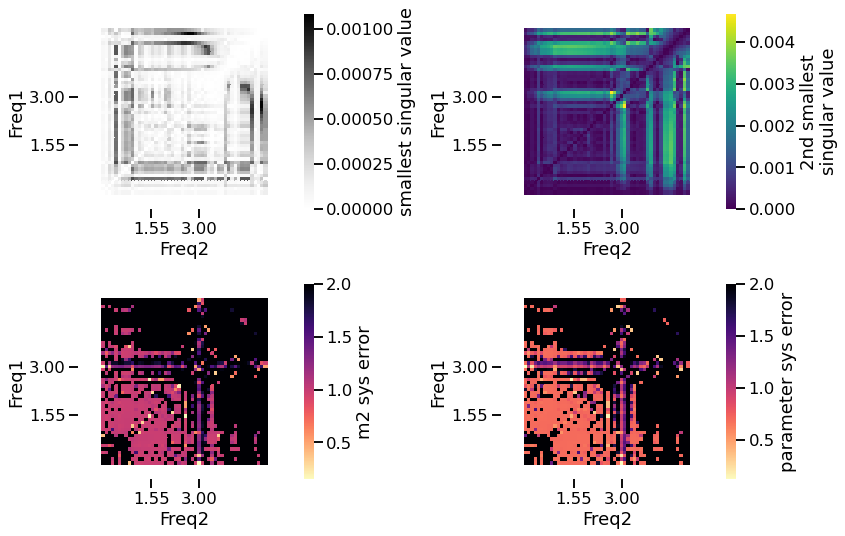

In [21]:

figsize = (12,10/1.3)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

print('Assuming 1D nullspace (where is this assumption ok?)')
print('Noiselevel: ' + str(noiselevel))

plt.sca(ax1)
lambdagrid=resultsdf.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambdagrid, "smallest singular value", cmap = 'Greys'); 

plt.sca(ax2)
lambda2grid=resultsdf.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'second smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambda2grid, "2nd smallest\nsingular value", cmap = 'viridis'); 

plt.sca(ax3)
errgrid=resultsdf.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'm2syserror').sort_index(axis = 0, ascending = False)
myheatmap(errgrid, "m2 sys error", vmax=2, cmap='magma_r'); 

plt.sca(ax4)
SSgrid=resultsdf.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'parametererror').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "parameter sys error",  vmax=2, cmap='magma_r'); 

for ax in [ax1,ax2,ax3,ax4]:
    plt.sca(ax)
    ax.axis('equal');
    plt.xticks([res1, res2])
    plt.yticks([res1, res2])

fig.tight_layout()

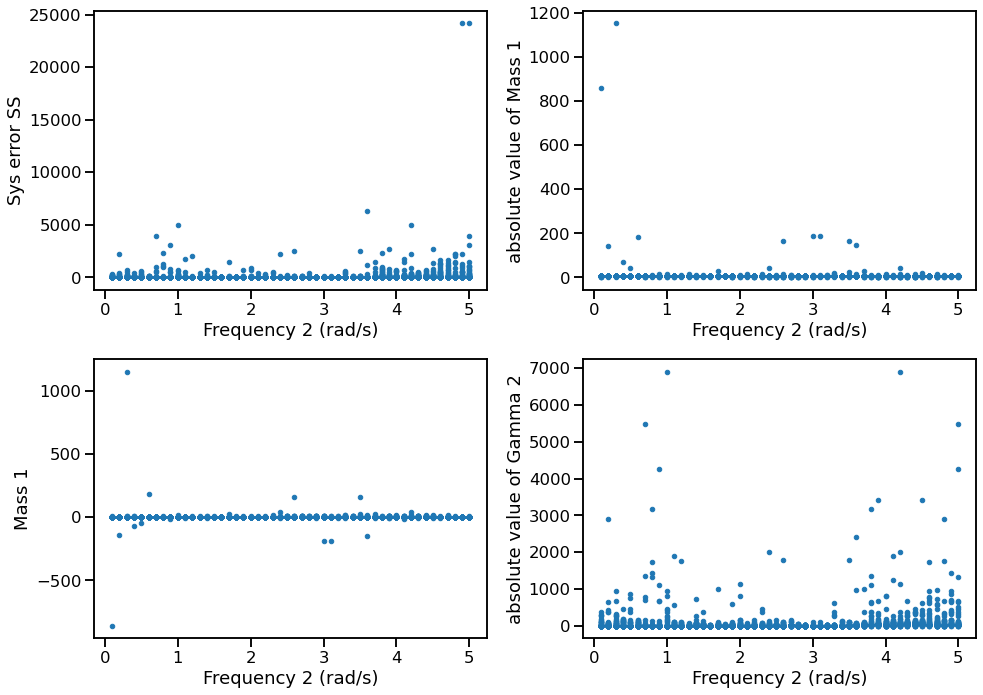

In [22]:
## Plot systematic error of parameters, sum of squares, as a function of the higher freq ***

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (14,10))

ax1.plot(resultsdf.Freq2,resultsdf.parametererror, '.')
ax1.set_xlabel('Frequency 2 (rad/s)')
ax1.set_ylabel('Sys error SS')
#ax1.set_title('Systematic error sum of squares')



ax2.plot(resultsdf.Freq2,abs(resultsdf.M1), '.')
ax2.set_ylabel('absolute value of Mass 1')
ax2.set_xlabel('Frequency 2 (rad/s)')

ax3.plot(resultsdf.Freq2,(resultsdf.M1), '.')
ax3.set_ylabel('Mass 1')
ax3.set_xlabel('Frequency 2 (rad/s)')

ax4.plot(resultsdf.Freq2,abs(resultsdf.G2), '.')
ax4.set_ylabel('absolute value of Gamma 2')
ax4.set_xlabel('Frequency 2 (rad/s)')

plt.tight_layout()


R1 Amp min =  0.10000000000000009 m 
R1 Phase min =  2.0 rad 
R2 Amp min =  -1.5000000000000002 m 
R2 Phase min =  -2.3000000000000003 rad


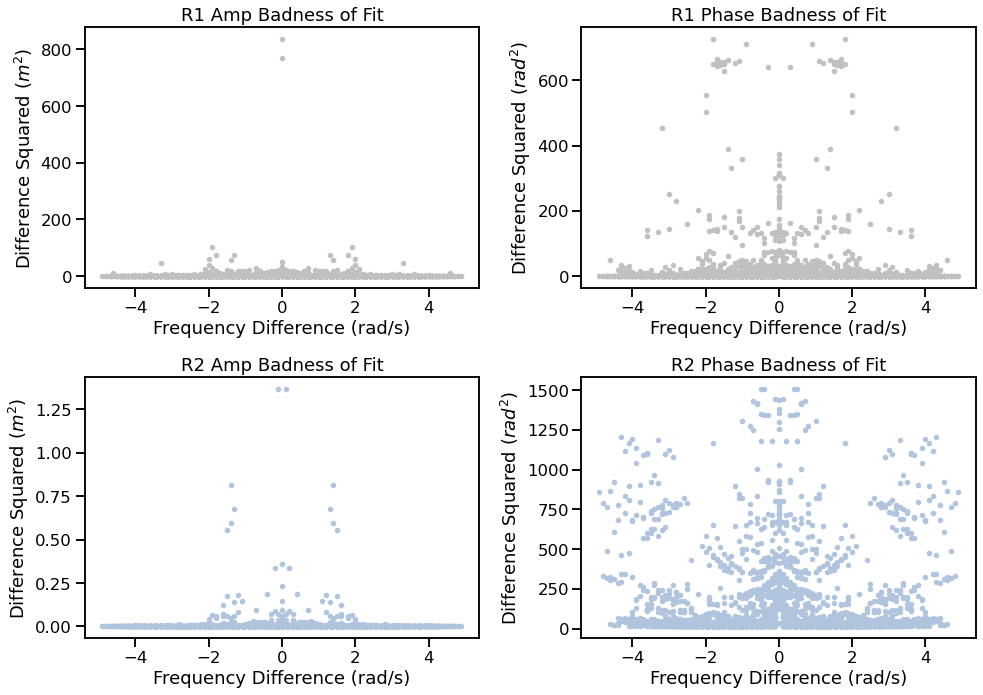

In [23]:
#Plots of badness of fits as a function of seperation between points

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (14,10))

ax1.plot(resultsdf.Difference, (resultsdf.R1AmpFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('R1 Amp Badness of Fit')
        
ax2.plot(resultsdf.Difference, (resultsdf.R1PhaseFit), '.', color = 'silver')
ax2.set_xlabel('Frequency Difference (rad/s)')
ax2.set_ylabel('Difference Squared ($rad^2$)')
ax2.set_title('R1 Phase Badness of Fit')     

ax3.plot(resultsdf.Difference, (resultsdf.R2AmpFit), '.', color = 'lightsteelblue')
ax3.set_xlabel('Frequency Difference (rad/s)')
ax3.set_ylabel('Difference Squared ($m^2$)')
ax3.set_title('R2 Amp Badness of Fit')
    
ax4.plot(resultsdf.Difference, (resultsdf.R2PhaseFit), '.', color = 'lightsteelblue')
ax4.set_xlabel('Frequency Difference (rad/s)')
ax4.set_ylabel('Difference Squared ($rad^2$)')
ax4.set_title('R2 Phase Badness of Fit')
        
plt.tight_layout()

#Print frequency difference with smallest badness of fit

print("R1 Amp min = ", resultsdf.iloc[resultsdf.R1AmpFit.idxmin()].Difference, "m",
     "\nR1 Phase min = ", resultsdf.iloc[resultsdf.R1PhaseFit.idxmin()].Difference, "rad",
     "\nR2 Amp min = ", resultsdf.iloc[resultsdf.R2AmpFit.idxmin()].Difference, "m",
     "\nR2 Phase min = ", resultsdf.iloc[resultsdf.R2PhaseFit.idxmin()].Difference, "rad")

Amp min =  -1.4000000000000001 m 
R1 Phase min =  -0.30000000000000027 rad


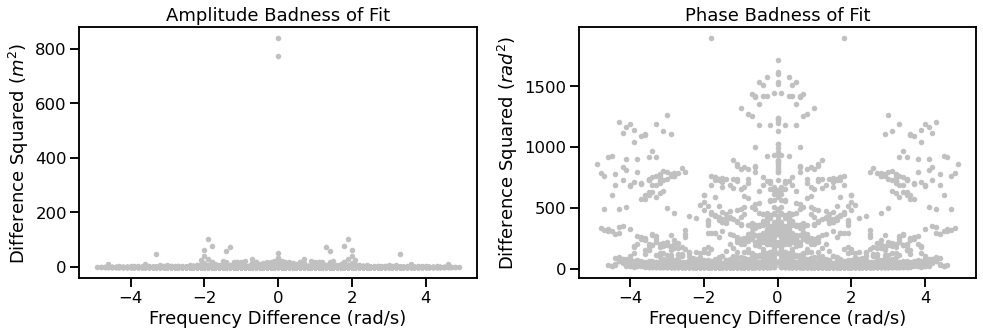

In [24]:
#Plot combined amplitude and phase Badness of Fit parameters

#Plots of badness of fits as a function of seperation between points

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (14,5))

ax1.plot(resultsdf.Difference, (resultsdf.R1AmpFit)+(resultsdf.R2AmpFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('Amplitude Badness of Fit')
        
ax2.plot(resultsdf.Difference, (resultsdf.R1PhaseFit)+(resultsdf.R2PhaseFit), '.', color = 'silver')
ax2.set_xlabel('Frequency Difference (rad/s)')
ax2.set_ylabel('Difference Squared ($rad^2$)')
ax2.set_title('Phase Badness of Fit')     

plt.tight_layout()

#Print frequency difference with smallest badness of fit

print("Amp min = ", resultsdf.iloc[resultsdf.R1AmpFit.idxmin()].Difference + 
      resultsdf.iloc[resultsdf.R2AmpFit.idxmin()].Difference, "m",
     "\nR1 Phase min = ", resultsdf.iloc[resultsdf.R1PhaseFit.idxmin()].Difference +
      resultsdf.iloc[resultsdf.R2PhaseFit.idxmin()].Difference, "rad")

Total min =  1.5 rad/s


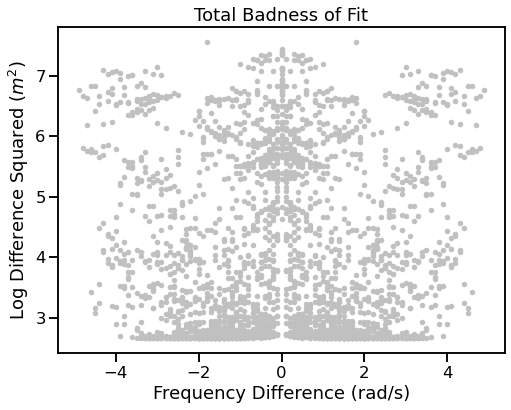

In [25]:
#Plots of badness of fits as a function of seperation between points

fig, (ax1) = plt.subplots(1, 1, figsize = (8,6))

ax1.plot(resultsdf.Difference, np.log(resultsdf.R1AmpFit + resultsdf.R2AmpFit + resultsdf.R1PhaseFit + resultsdf.R2PhaseFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Log Difference Squared ($m^2$)')
ax1.set_title('Total Badness of Fit')

print("Total min = ", resultsdf.iloc[(resultsdf.R1AmpFit + resultsdf.R2AmpFit + resultsdf.R1PhaseFit + resultsdf.R2PhaseFit).idxmin()].Difference, "rad/s")

Total min =  1.5 rad/s


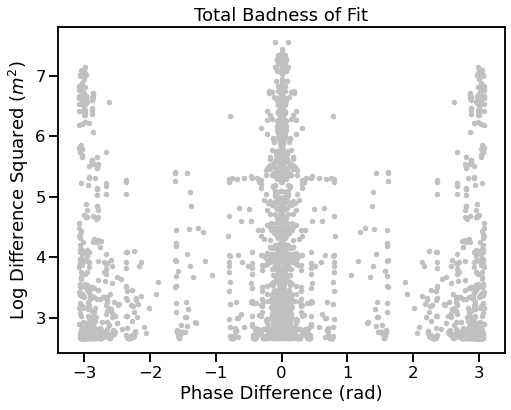

In [26]:
#Plots of badness of fits as a function of seperation between points

fig, (ax1) = plt.subplots(1, 1, figsize = (8,6))

ax1.plot(resultsdf.R1_phase_diff, np.log(resultsdf.R1AmpFit + resultsdf.R2AmpFit + resultsdf.R1PhaseFit + resultsdf.R2PhaseFit), '.', color = 'silver')
ax1.set_xlabel('Phase Difference (rad)')
ax1.set_ylabel('Log Difference Squared ($m^2$)')
ax1.set_title('Total Badness of Fit')

print("Total min = ", resultsdf.iloc[(resultsdf.R1AmpFit + resultsdf.R2AmpFit + resultsdf.R1PhaseFit + resultsdf.R2PhaseFit).idxmin()].Difference, "rad/s")

**Sweep through starting points**

In [27]:
#Code that loops through points of different spacing

interval = 10

j = 1

max_vals = []

while j < (n - interval):
    
    #Define starting point and interval
    start = j


    #initiate arrays for badness of fit values
    fits = []

    #Start table with starting point
    tab = [[drive[start], R1_amp[start], R1_phase[start], R2_amp[start], R2_phase[start]]]

    i = 1 

    while i < (n - start):
    
        #Append next data point to table and add to dataframe
        tab.append([drive[start + i], R1_amp[start + i], R1_phase[start + i], R2_amp[start + i], R2_phase[start + i]])
    
        df_vals = pd.DataFrame(data = tab, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])
    
        #Calculate complex values   
        ampComplex = []
    
        Z1_1 = df_vals['R1Amp'][0] * np.exp(1j * df_vals['R1Phase'][0])
        Z2_1 = df_vals['R2Amp'][0] * np.exp(1j * df_vals['R2Phase'][0])
    
        Z1_2 = df_vals['R1Amp'][1] * np.exp(1j * df_vals['R1Phase'][1])
        Z2_2 = df_vals['R2Amp'][1] * np.exp(1j * df_vals['R2Phase'][1])
    
        ampComplex.append([Z1_1, Z2_1])
        ampComplex.append([Z1_2, Z2_2])

        df_vals['R1AmpCom'], df_vals['R2AmpCom'] = np.transpose(ampComplex)

        #define which two points to use for analysis
        vals1 = df_vals.loc[0]
        vals2 = df_vals.loc[1]

        #define values for svd
        d1 = vals1['drive']
        d1Z1 = vals1['R1AmpCom']
        d1Z2 = vals1['R2AmpCom']

        d2 = vals2['drive']
        d2Z1 = vals2['R1AmpCom']
        d2Z2 = vals2['R2AmpCom']
    
        M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
            [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
            [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
            [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
            [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
            [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
            [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
            [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

        #SVD
        u, s, vh = np.linalg.svd(M, full_matrices = True)
    
        #assign variables
        [M1, M2, G1, G2, K1, K2, K12, FD] = vh[7]
    
        #calculate badness of fit for R1 and R2 amplitudes and phases and add to arrays
        max_vals.append([drive[start], drive[start + i] - drive[start], 
                np.sum(R1_amp - curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2 + 
                np.sum((R1_phase - theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2) +
                np.sum((R2_amp - curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2) +
                np.sum((R2_phase - theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)])
    
        #remove data from table and dataframe to start over
        tab.pop()
    
        i = i + interval
        
    j = j + interval
    
maxes = pd.DataFrame(data = max_vals, columns = ['Starting Freq', 'FreqDiff', 'TotalFit'])

In [28]:
#maxes

C:\Users\vhorowit\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Total Badness of Fit')

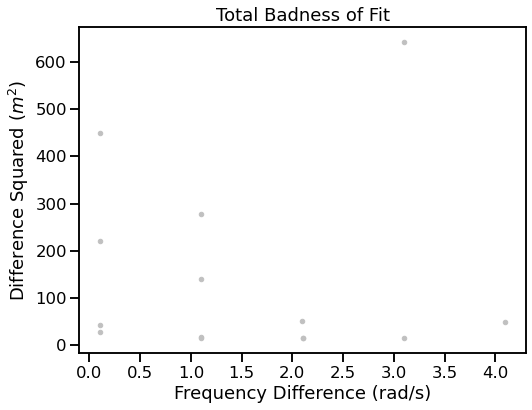

In [29]:
#Plots of badness of fits as a function of seperation between points

fig, (ax1) = plt.subplots(1, 1, figsize = (8,6))

ax1.plot(maxes.FreqDiff, (maxes.TotalFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('Total Badness of Fit')

# Sweep error to see effect of difference squared values

In [30]:
#define points for SVD

points = [int(50/4), int(70/4)]

#define drive frequencies
drive = np.linspace(0.1, 5, num = n)

results = []

amplitudeadder = 0

interval = 0.001

#Amplitudes and phases with no error
R1amp = curve1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R1phase = theta1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2amp = curve2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2phase = theta2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)

def complexAmp(df, ampComplex=[]):
    #Use amplitude and phase to calculate complex amplitude
    Z1 = df['R1Amp'] * np.exp(1j * df['R1Phase'])
    Z2 = df['R2Amp'] * np.exp(1j * df['R2Phase'])

    #Add complex amplitude to table to append to dataframe
    ampComplex.append([Z1, Z2])

while amplitudeadder < 0.05 :

    #Put amplitude and phase values in table and add error
    tabl = []
    
    for j in range(len(points)):
        tabl.append([drive[points[j]], R1amp[points[j]] + amplitudeadder, R1amp[points[j]] + amplitudeadder,
                      R2amp[points[j]] + amplitudeadder, R2amp[points[j]] + amplitudeadder])

    df = pd.DataFrame(data = tabl, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])

    #Define complex amplitudes
    #Define function to calculate phase correction and complex amplitudes

    ampComplex = []

    for j in range(df.shape[0]):
        complexAmp(df.iloc[j], ampComplex)

    df['R1AmpCom'], df['R2AmpCom'] = np.transpose(ampComplex)
    
    #Singular Value Decomposition

    #define which two points to use for analysis
    vals1 = df.loc[0]
    vals2 = df.loc[1]

    #define values for svd
    d1 = vals1['drive']
    d1Z1 = vals1['R1AmpCom']
    d1Z2 = vals1['R2AmpCom']

    d2 = vals2['drive']
    d2Z1 = vals2['R1AmpCom']
    d2Z2 = vals2['R2AmpCom']

    #Define Matrix M
    M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
            [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
            [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
            [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
            [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
            [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
            [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
            [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

    #SVD
    u, s, vh = np.linalg.svd(M, full_matrices = True)
    #u, s, vh = sc.linalg.svd(M, full_matrices = False, lapack_driver = 'gesvd')

    
    #assign variables
    [M1, M2, G1, G2, K1, K2, K12, FD] = vh[-1]
    
    #calculate badness of fit for R1 and R2 amplitudes and phases and add to arrays
    results.append([drive[points[1]] - drive[points[0]], amplitudeadder,
                np.sum(R1amp - curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2, 
                np.sum((R1phase - theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                np.sum((R2amp - curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                np.sum((R2phase - theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)])
    
    #remove data from table and dataframe to start over
    tabl.pop()
    
    amplitudeadder = amplitudeadder + interval
    
errors = pd.DataFrame(data = results, columns = ['Difference','error', 'R1AmpFit', 'R1PhaseFit', 'R2AmpFit', 'R2PhaseFit'])

C:\Users\vhorowit\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


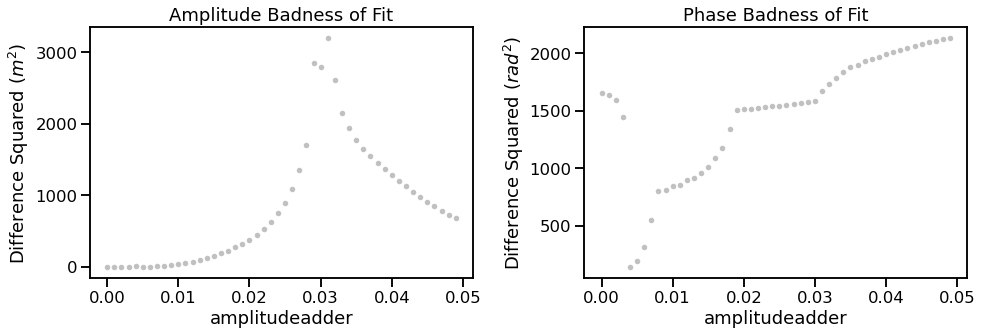

In [31]:
#Plot combined amplitude and phase Badness of Fit parameters

#Plots of badness of fits as a function of seperation between points

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (14,5))

ax1.plot(errors.error, (errors.R1AmpFit)+(errors.R2AmpFit), '.', color = 'silver')
ax1.set_xlabel('amplitudeadder')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('Amplitude Badness of Fit')
        
ax2.plot(errors.error, (errors.R1PhaseFit)+(errors.R2PhaseFit), '.', color = 'silver')
ax2.set_xlabel('amplitudeadder')
ax2.set_ylabel('Difference Squared ($rad^2$)')
ax2.set_title('Phase Badness of Fit')     

plt.tight_layout()